# Particle Swarm Optimization: basics

Particle swarm optimization (PSO), first proposed by [Eberhart and Kennedy (1995)](#eberhart1995optimizer), is a population-based algorithm which intends for simulating the social behavior of a bird flock (swarm of particles) to reach the optimum region of the search space.

PSO is quite recent in the framework of geophysical data inversion ([Shaw and Srivastava, 2007](#shaw2007particle); [Yuan et al., 2009](#yuan2009swarm)) and is not yet widely used like well-known global optimization methods such as Monte-Carlo ([Metropolis and Ulam, 1949](#metropolis1949monte); [Mosegaard and Tarantola, 1995](#mosegaard1995monte); [Mosegaard and Sambridge, 2002](#mosegaard2002monte); [Socco and Boiero, 2008](#socco2008improved)), simulated-annealing ([Ryden and Park, 2006](#ryden2006fast)) or neighbourhood algorithm ([Sambridge, 1999a](#sambridge1999geophysicala),[b](#sambridge1999geophysicalb), [2001](#sambridge2001finding)). However, it was successfully applied to surface-wave dispersion curve inversion ([Song et al., 2012](#song2012application); [Wilken and Rabbel, 2012](#wilken2012application)), traveltime tomography ([Tronicke et al., 2012](#tronicke2012crosshole); [Luu et al., 2016)](#luu2016competitive), seismic refraction ([Poormirzaee et al., 2014](#poormirazee2014introducing)) and seismic wave impedance inversion in igneous rock ([Yang et al., 2017](#yang2017particle)).

## Method

In PSO, individuals ($i$), or particles, are characterized by a velocity vector <img src="http://mathurl.com/y7yjm477.png"> and a position vector <img src="http://mathurl.com/y7qb75kn.png"> in D-dimensional solution space. All particles are
initialized with random values at the beginning of the inversion process and the corresponding velocity
vectors are set to zero.

The standard PSO update formulas are (Eberhart and Kennedy, 1995):

<img src="http://mathurl.com/yddzjty6.png">

## A simple example

In [1]:
# Import matplotlib and numpy modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import the Swarm class from NeSSI
from nessi.pso import Swarm

### 1-The peak function

The Peaks function in Equation 6 is a function of two
variables,  obtained  by  translating  and  scaling  Gaussian
distributions.  It  has  multiple  peaks  which  are  located
at  (0,1.58),  (0.46,0.63),  and  (1.28,0)  with  different  peak
function values (Aljarah & Ludwig, 2013). The function has the following definition:
    
<img src="http://mathurl.com/y8pqzht8.png">

In [2]:
def peaksF(X, Y):
    F = 3.*(1.-X)*(1.-X)\
                *np.exp(-1.*X**2-(Y+1.)**2)\
                -10.*(X/5.-X**3-Y**5)\
                *np.exp(-1.*X**2-Y**2)\
                -1./3.*np.exp(-1.*(X+1)**2-Y**2)

    return F

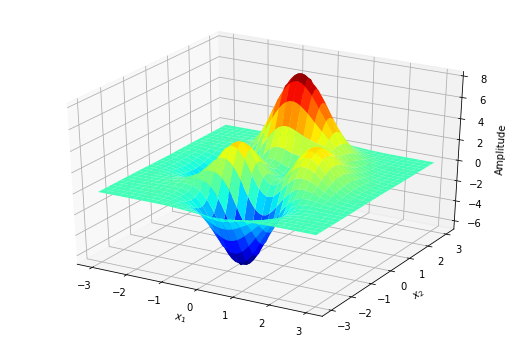

In [3]:
# Initialize 3D plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.set_xlabel(r'$x_{1}$')
ax.set_ylabel(r'$x_{2}$')
ax.set_zlabel(r'Amplitude')

# Calculate peak function
X, Y = np.meshgrid(np.linspace(-3, 3, 61), np.linspace(-3, 3, 61))
F = peaksF(X, Y)

# Plot
ax.plot_surface(X, Y, F, vmin=-6.0, vmax=8.0, cmap='jet');

### 2-Define the search-space

The search-space is delimited by the minimum and maximum values of each parameter (x1 and x2 in this case). An increment value (dx) is added to control the maximum displacement of the swarm's particles.

| x1 min | x1 max | dx1 | x2 min | x2 max | dx2 |
| ------ | ------ | --- | ------ | ------ | --- |
| -3.0   | 3.0    | 0.3 | -3.0   | 3.0    | 0.3 |

### 3-Process

In [4]:
# Initialize the swarm object
swarm = Swarm()

# PSO parameters
ngen = 100
nindv = 20
fit = np.zeros((ngen+1, 2), dtype=np.float32)

# Get the search-space
# Alternatively, the search space can be loaded from a text file using the function
#     swarm.init_pspace('name_of_the_file')
# The file must be formatted as follow:
# - one line per point
# - for each line: x1min, x1max, dx1, ..., xNmin, xNmax, dxN
# - comments='#'
# Here, only one point is searched: the one for which the two parameters (X, Y) 
# gives the minimum value of the 2D peak function.
swarm.pspace = np.array([[[-3.0, 3.0, 0.3],
                          [-3.0, 3.0, 0.3]]], 
                        dtype=np.float32)

# Initialize particles
swarm.init_particles(nindv)

In [5]:
# First evaluation
swarm.misfit[:] = peaksF(swarm.current[:, 0, 0], swarm.current[:, 0, 1])
fit[0, 0] = np.amin(swarm.misfit)
fit[0, 1] = np.mean(swarm.misfit)

In [6]:
# Loop over generations
for igen in range(0, ngen):
    # Update
    swarm.update(control=1)
    # Evaluation
    for indv in range(0, nindv):
        vfit = peaksF(swarm.current[indv, 0, 0], swarm.current[indv, 0, 1])
        if vfit < swarm.misfit[indv]:
            swarm.history[indv, :, :] = swarm.current[indv, :, :]
            swarm.misfit[indv] = vfit
    # Store the misfit values
    fit[igen+1, 0] = np.amin(swarm.misfit)
    fit[igen+1, 1] = np.mean(swarm.misfit)

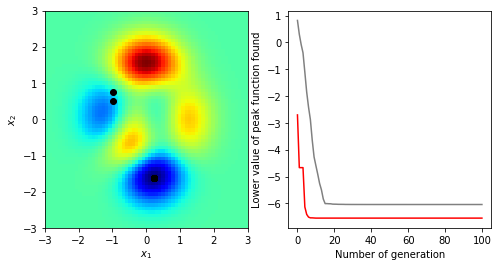

In [7]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(-3.0, 3.0)
ax1.set_ylim(-3.0, 3.0)
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
ax1.imshow(F, aspect='auto', cmap='jet', extent=[-3.0, 3.0, -3.0, 3.0], origin='upper-left')
ax1.scatter(swarm.history[:, 0, 0], swarm.history[:, 0, 1], color='black')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel('Number of generation')
ax2.set_ylabel('Lower value of peak function found')
ax2.plot(fit[:, 0], color='red')
ax2.plot(fit[:, 1], color='gray');

## References

<a name="aljarah2013mapreduce" style="color: rgb(0,0,0)">Aljarah, I. & Ludwig, S. (2013). A MapReduce based Glowworm Swarm Optimization Approach for Multimodal Functions. *10.1109/SIS.2013.6615155*.</a>

<a name="eberhart1995optimizer" style="color: rgb(0,0,0)">Eberhart, R., & Kennedy, J. (1995, October). A new optimizer using particle swarm theory. *In Micro Machine and Human Science, 1995. MHS'95., Proceedings of the Sixth International Symposium on (pp. 39-43). IEEE.*</a>

<a name="luu2016competitive" style="color: rgb(0,0,0)">Luu, K., Noble, M., & Gesret, A. (2016, January). A competitive particle swarm optimization for nonlinear first arrival traveltime tomography. *In 2016 SEG International Exposition and Annual Meeting. Society of Exploration Geophysicists*.</a>

<a name="metropolis1949monte" style="color: rgb(0,0,0)">Metropolis, N., & Ulam, S. (1949). The monte carlo method. *Journal of the American statistical association, 44(247)*, 335-341.</a>

<a name="mosegaard1995monte" style="color: rgb(0,0,0)">Mosegaard, K., & Tarantola, A. (1995). Monte Carlo sampling of solutions to inverse problems. *Journal of Geophysical Research: Solid Earth, 100(B7)*, 12431-12447.</a>

<a name="mosegaard2002monte" style="color: rgb(0,0,0)">Mosegaard, K., & Sambridge, M. (2002). Monte Carlo analysis of inverse problems. *Inverse problems, 18(3)*, R29.</a>

<a name="poormirazee2014introducing" style="color: rgb(0,0,0)">Poormirzaee, R., Moghadam, R. H., & Zarean, A. (2014, September). Introducing Particle Swarm Optimization (PSO) to Invert Refraction Seismic Data. *In Near Surface Geoscience 2014-20th European Meeting of Environmental and Engineering Geophysics*.</a>

<a name="ryden2006fast" style="color: rgb(0,0,0)">Ryden, N., & Park, C. B. (2006). Fast simulated annealing inversion of surface waves on pavement using phase-velocity spectra. *Geophysics, 71(4)*, R49-R58.</a>

<a name="sambridge1999geophysicala" style="color: rgb(0,0,0)">Sambridge, M. (1999), Geophysical inversion with a neighbourhood algorithm—I. Searching a parameter space. *Geophysical Journal International, 138*: 479-494.</a> 

<a name="sambridge1999geophysicalb" style="color: rgb(0,0,0)">Sambridge, M. (1999). Geophysical inversion with a neighbourhood algorithm—II. Appraising the ensemble. *Geophysical Journal International, 138(3)*, 727-746.</a>

<a name="sambridge2001finding" style="color: rgb(0,0,0)">Sambridge, M. (2001). Finding acceptable models in nonlinear inverse problems using a neighbourhood algorithm. *Inverse Problems, 17(3)*, 387.</a>

<a name="shaw2007particle" style="color: rgb(0,0,0)">Shaw, R., & Srivastava, S. (2007). Particle swarm optimization: A new tool to invert geophysical data. *Geophysics, 72(2)*, F75-F83.</a>

<a name="shi1998modified" style="color: rgb(0,0,0)">Shi, Y., & Eberhart, R. (1998, May). A modified particle swarm optimizer. In *Evolutionary Computation Proceedings, 1998. IEEE World Congress on Computational Intelligence., The 1998 IEEE International Conference on (pp. 69-73). IEEE.*</a>

<a name="socco2008improved" style="color: rgb(0,0,0)">Socco, L. V., & Boiero, D. (2008). Improved Monte Carlo inversion of surface wave data. *Geophysical Prospecting, 56(3)*, 357-371.</a>

<a name="song2012application" style="color: rgb(0,0,0)">Song, X., Tang, L., Lv, X., Fang, H., & Gu, H. (2012). Application of particle swarm optimization to interpret Rayleigh wave dispersion curves. *Journal of Applied Geophysics, 84*, 1-13.</a>

<a name="tronicke2012crosshole" style="color: rgb(0,0,0)">Tronicke, J., Paasche, H., & Böniger, U. (2012). Crosshole traveltime tomography using particle swarm optimization: A near-surface field example. *Geophysics, 77(1)*, R19-R32.</a>

<a name="wilken2012application" style="color: rgb(0,0,0)">Wilken, D., & Rabbel, W. (2012). On the application of particle swarm optimization strategies on Scholte-wave inversion. *Geophysical Journal International, 190(1)*, 580-594.</a>

<a name="yang2017particle" style="color: rgb(0,0,0)">Yang, H., Xu, Y., Peng, G., Yu, G., Chen, M., Duan, W., ... & Wang, X. (2017). Particle swarm optimization and its application to seismic inversion of igneous rocks. *International Journal of Mining Science and Technology, 27(2)*, 349-357.</a>

<a name="yuan2009swarm" style="color: rgb(0,0,0)">Yuan, S., Wang, S., & Tian, N. (2009). Swarm intelligence optimization and its application in geophysical data inversion. *Applied Geophysics, 6(2)*, 166-174.</a>